# MODEL 0: DEEPLABV3 WITH PRETRAINED WEIGHTS (No Finetunning)

### Part 0: Setting up the environment

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.utils.data import DataLoader
from torchvision.io import read_image
import torch.nn.functional as F
import numpy as np
import time, os, json
from tqdm import tqdm
import glob
import kagglehub
import matplotlib.pyplot as plt

### Part 1: Configurating datasets and functions

In [2]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download and extract Kaggle dataset
base_path = kagglehub.dataset_download("triminhtran/csce670-segmentation-dataset")
image_dir = os.path.join(base_path, "JPEGImages")
mask_dir = os.path.join(base_path, "SegmentationClass")

# Dataset Class
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
        self.mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.png')))
        self.transform = transform
        self.mask_transform = T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = read_image(self.image_paths[idx]).float() / 255.0
        mask = read_image(self.mask_paths[idx])[0]

        if self.transform:
            img = self.transform(img)
        
        # Resize mask to match image dimensions
        mask = self.mask_transform(mask.unsqueeze(0)).squeeze(0)

        return img, mask
    
# Metrics Calculation
def calculate_metrics(pred, target):
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()

    intersection = np.logical_and(target, pred).sum()
    union = np.logical_or(target, pred).sum()

    iou = intersection / union
    pixel_acc = (pred == target).mean()
    precision = intersection / pred.sum()
    recall = intersection / target.sum()

    return iou, pixel_acc, precision, recall

### Part 2: Loading dataset and model

In [ ]:
# Load Data
train_data = SegmentationDataset(
    image_dir, mask_dir,
    transform=T.Resize((256, 256))
)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(train_data, batch_size=1)

# Load Model
model = deeplabv3_resnet50(pretrained=True).to(device)
model.eval()

# Model Parameter Count
param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
torch.save(model.state_dict(), "deeplabv3_pretrained_noft.pth")
storage_size = os.path.getsize("deeplabv3_pretrained_noft.pth") / (1024 ** 2)  # MB

# Track Metrics
metrics_summary = {
    "param_count": param_count,
    "storage_size_MB": storage_size,
    "inference_time_per_image": [],
    "gpu_memory_MB": [],
    "cpu_usage_percent": [],
    "iou": [],
    "pixel_accuracy": [],
    "precision": [],
    "recall": []
}

### Part 3: Evaluating

In [ ]:
# Start evaluation loop
with torch.no_grad():
    for images, masks in tqdm(test_loader):
        images, masks = images.to(device), masks.to(device)
        torch.cuda.reset_peak_memory_stats(device)

        start = time.time()
        outputs = model(images)['out']
        inference_time = time.time() - start
        metrics_summary["inference_time_per_image"].append(inference_time)

        gpu_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
        metrics_summary["gpu_memory_MB"].append(gpu_memory)

        preds = outputs.argmax(1)
        iou, pixel_acc, precision, recall = calculate_metrics(preds, masks)

        metrics_summary["iou"].append(iou)
        metrics_summary["pixel_accuracy"].append(pixel_acc)
        metrics_summary["precision"].append(precision)
        metrics_summary["recall"].append(recall)

# Save Metrics
with open("deeplabv3_pretrained_noft_metrics.json", "w") as f:
    json.dump(metrics_summary, f, indent=4)

print("Metrics saved to deeplabv3_pretrained_noft_metrics.json")

  0%|          | 0/537 [00:00<?, ?it/s]C:\Users\TriTran\AppData\Local\Temp\ipykernel_53848\3249961206.py:40: RuntimeWarning: invalid value encountered in scalar divide
  iou = intersection / union
C:\Users\TriTran\AppData\Local\Temp\ipykernel_53848\3249961206.py:42: RuntimeWarning: invalid value encountered in scalar divide
  precision = intersection / pred.sum()
C:\Users\TriTran\AppData\Local\Temp\ipykernel_53848\3249961206.py:43: RuntimeWarning: invalid value encountered in divide
  recall = intersection / target.sum()
100%|██████████| 537/537 [00:04<00:00, 129.47it/s]

Metrics saved to deeplabv3_metrics.json


### Part 4: Visualize a batch

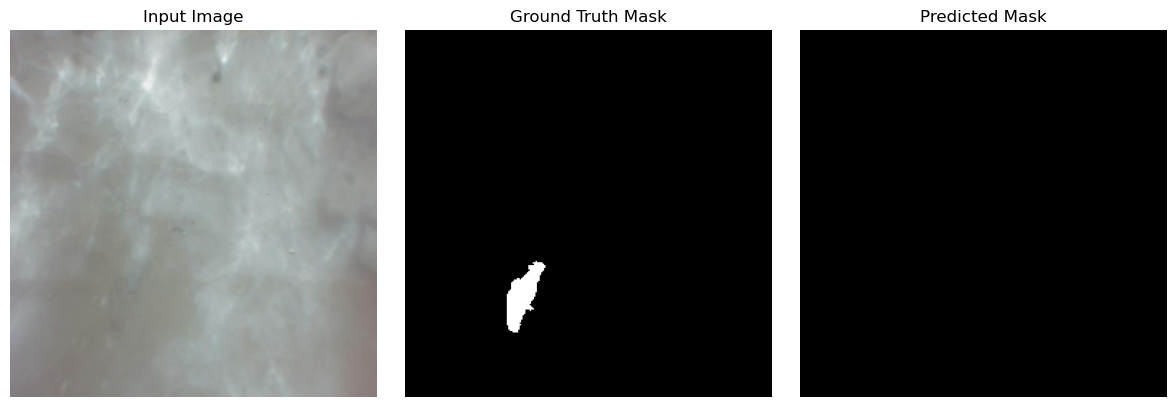

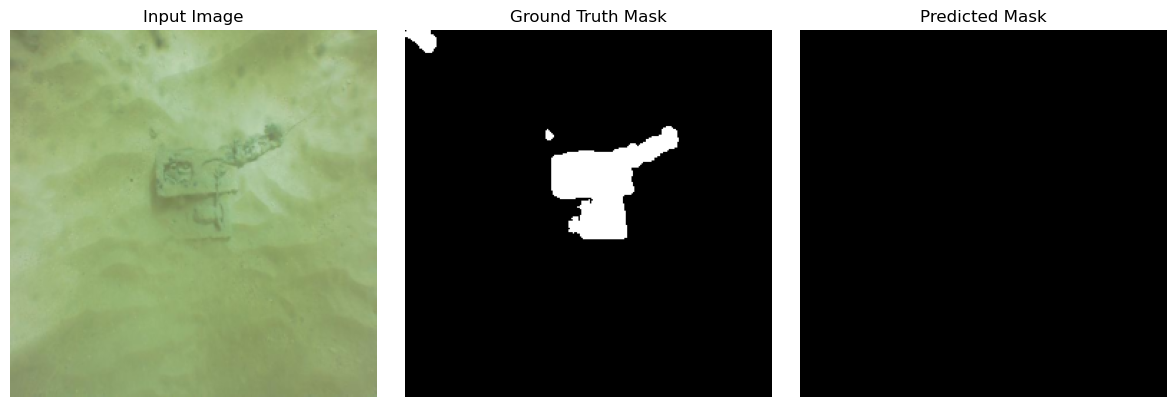

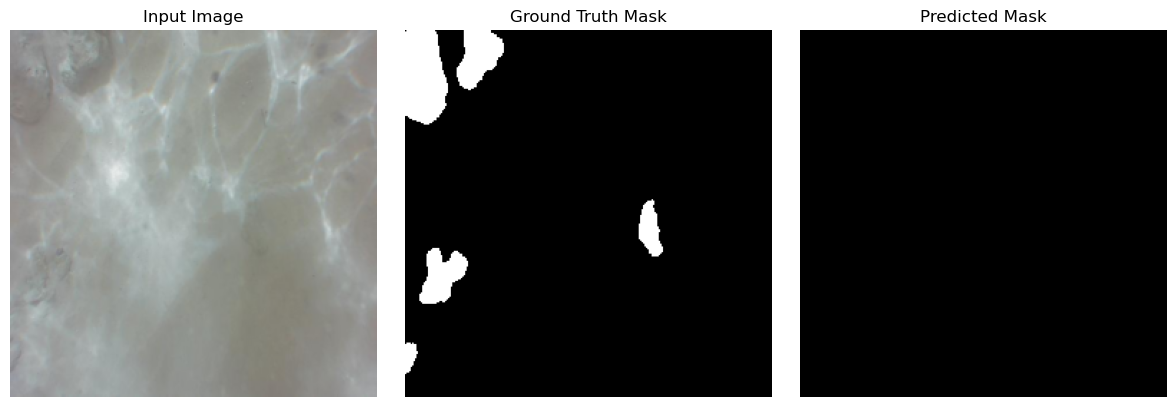

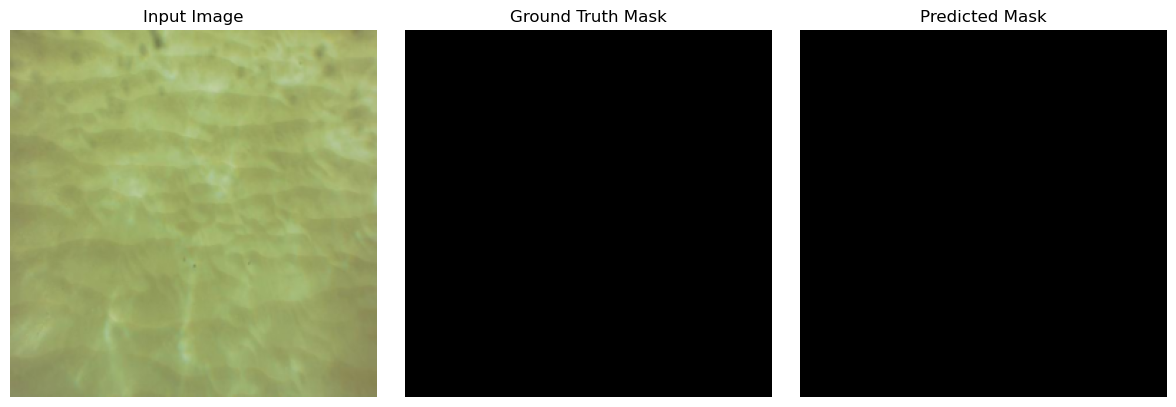

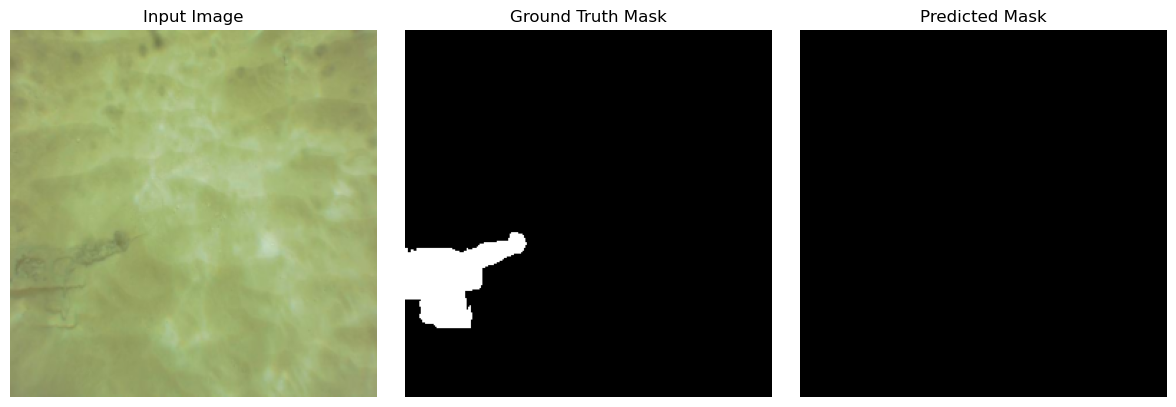

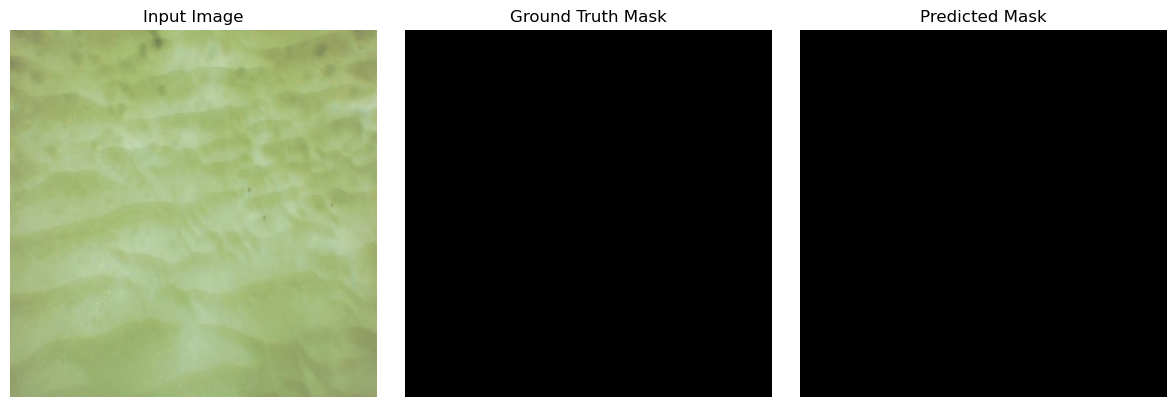

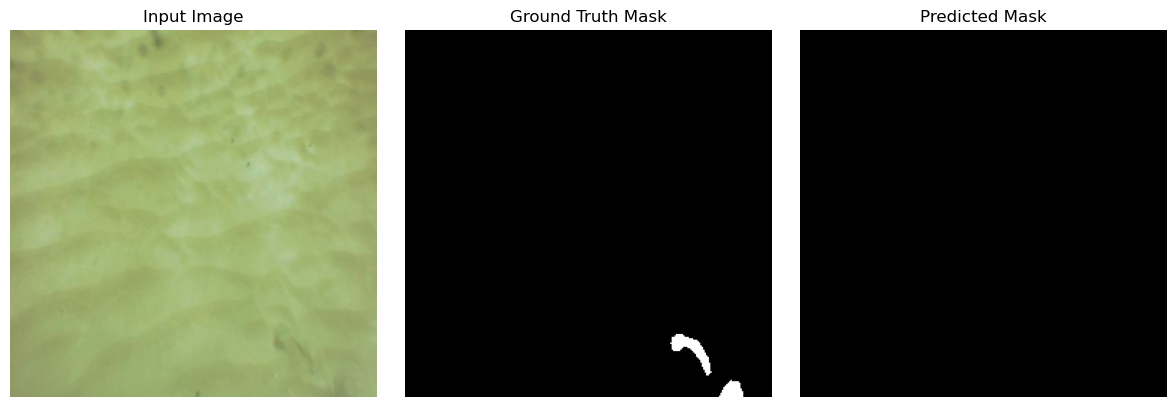

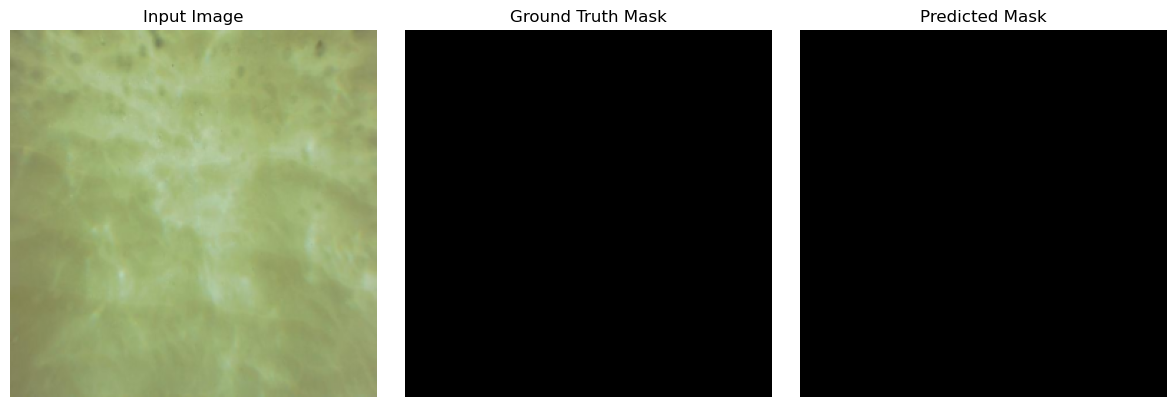

In [5]:
# Visualization of sample predictions
sample_images, sample_masks = next(iter(train_loader))
batch_size = sample_images.shape[0]

with torch.no_grad():
    sample_images_gpu = sample_images.float().to(device)
    output = model(sample_images_gpu)['out']
    predicted_masks = torch.argmax(output, dim=1).cpu()

for i in range(batch_size):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(torch.permute(sample_images[i], (1, 2, 0)))
    axs[0].set_title("Input Image")
    axs[0].axis("off")

    axs[1].imshow(sample_masks[i], cmap='gray')
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(predicted_masks[i], cmap='gray')
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

### Part 5: Visualization

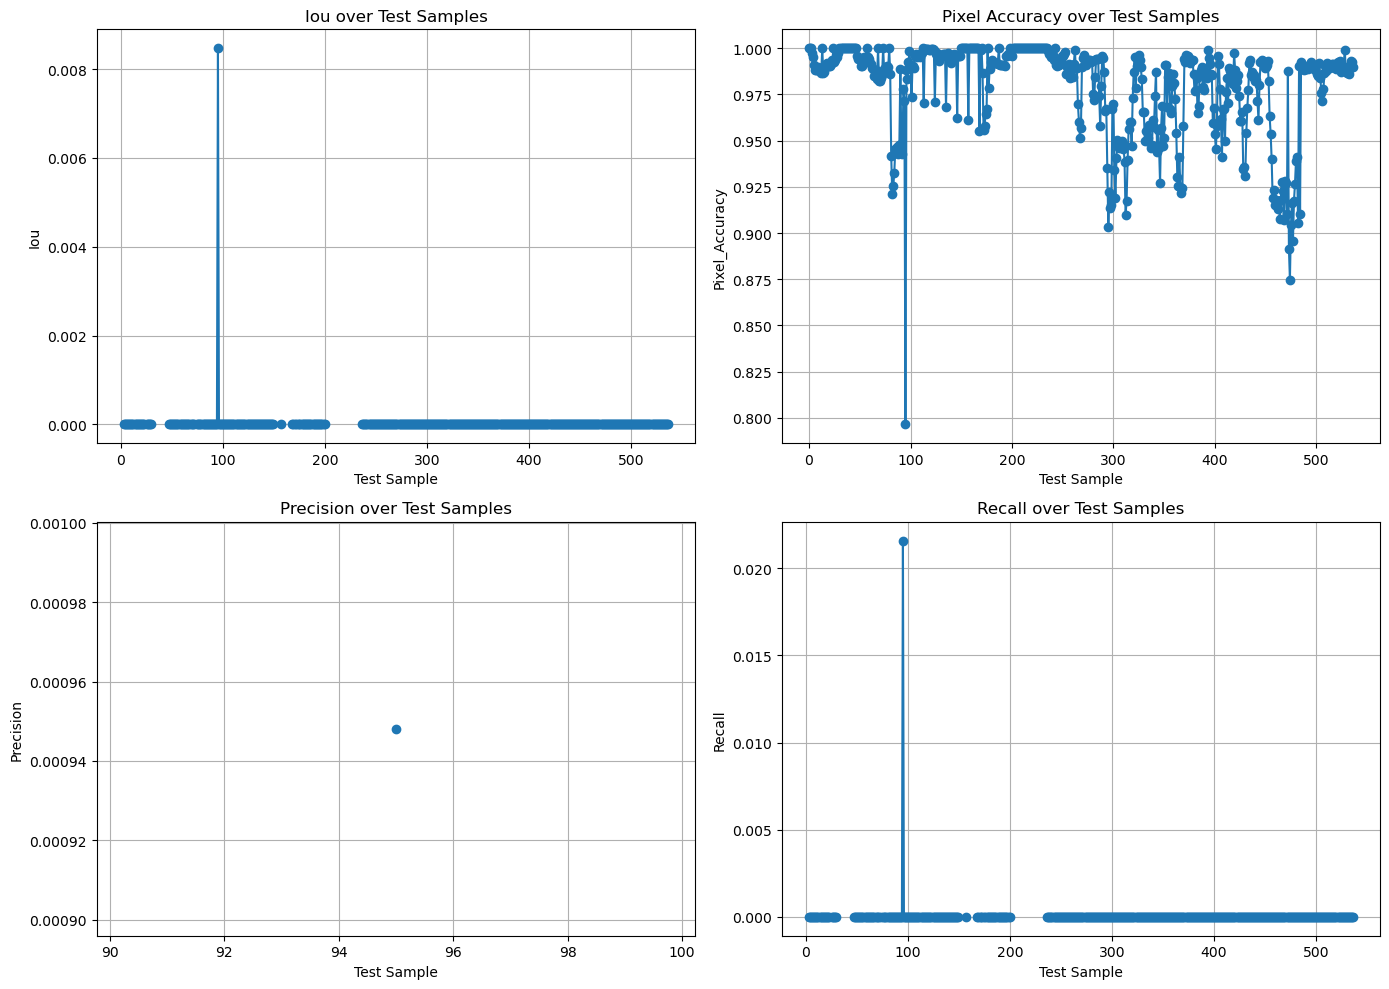

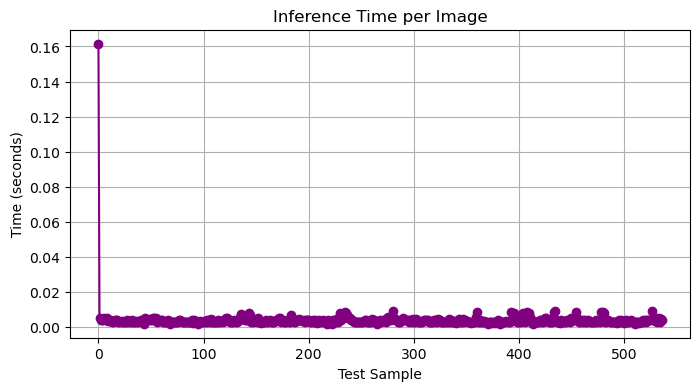

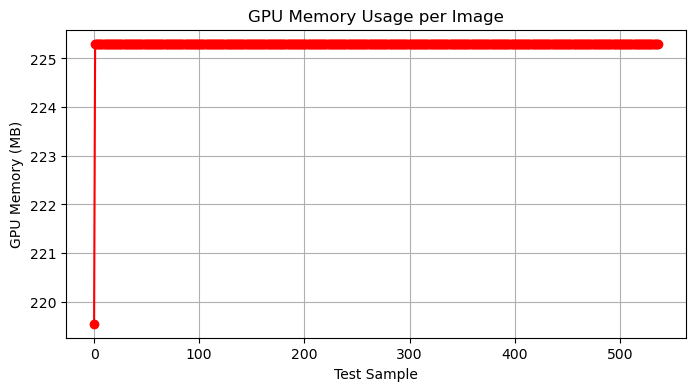

Total Parameter Count: 42,004,074
Model Storage Size: 160.58 MB


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load metrics from JSON file
with open("deeplabv3_pretrained_noft_metrics.json", "r") as f:
    metrics = json.load(f)

# Plot IoU, Pixel Accuracy, Precision, and Recall
metrics_names = ['iou', 'pixel_accuracy', 'precision', 'recall']
plt.figure(figsize=(14, 10))

for i, metric_name in enumerate(metrics_names, 1):
    plt.subplot(2, 2, i)
    plt.plot(metrics[metric_name], marker='o')
    plt.title(f'{metric_name.replace("_", " ").title()} over Test Samples')
    plt.xlabel('Test Sample')
    plt.ylabel(metric_name.title())
    plt.grid(True)

plt.tight_layout()
plt.show()

# Visualize Inference Time per Image
plt.figure(figsize=(8, 4))
plt.plot(metrics['inference_time_per_image'], marker='o', color='purple')
plt.title('Inference Time per Image')
plt.xlabel('Test Sample')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.show()

# GPU Memory Usage per Image
plt.figure(figsize=(8, 4))
plt.plot(metrics['gpu_memory_MB'], marker='o', color='red')
plt.title('GPU Memory Usage per Image')
plt.xlabel('Test Sample')
plt.ylabel('GPU Memory (MB)')
plt.grid(True)
plt.show()

# Summary Statistics for CPU Usage, Parameter Count, and Storage Size
print(f"Total Parameter Count: {metrics['param_count']:,}")
print(f"Model Storage Size: {metrics['storage_size_MB']:.2f} MB")
